In [3]:
from datasets import load_dataset
from torch.utils.data import DataLoader, Dataset
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
from fastprogress.fastprogress import master_bar, progress_bar
from sklearn.metrics import f1_score

In [4]:
class SequenceModel(nn.Module):
    def __init__(self):
        super(SequenceModel, self).__init__()
        self.num_positions = 9
        self.num_embeddings = 1024
        self.embedding_dim = 6
        
        self.embeddings = nn.ModuleList([
            nn.Embedding(num_embeddings=self.num_embeddings, embedding_dim=self.embedding_dim) 
            for _ in range(self.num_positions)
        ])
        
        self.conv1 = nn.Conv1d(in_channels=54,  out_channels=72,  kernel_size=3, stride=3)
        self.conv2 = nn.Conv1d(in_channels=72,  out_channels=120, kernel_size=3, stride=3)
        
        self.fc1 = nn.Linear(120, 120)
        self.fc2 = nn.Linear(120, 24)
    
    def forward(self, x):
        batch_size = x.shape[0]
        embeddings = [self.embeddings[i](x[:, :, i]) for i in range(self.num_positions)]
        embeddings = torch.stack(embeddings, dim=3)
        reshaped = embeddings.view(batch_size, 54, -1)
        x = F.relu(self.conv1(reshaped))
        x = F.relu(self.conv2(x))
        x = x.view(batch_size, -1)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

In [5]:
dataset = load_dataset("danjacobellis/audio_har_descript_44kHz_frames",split='train').with_format("torch",device="cuda")
model = SequenceModel().to("cuda")
loss_function = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=0.001)

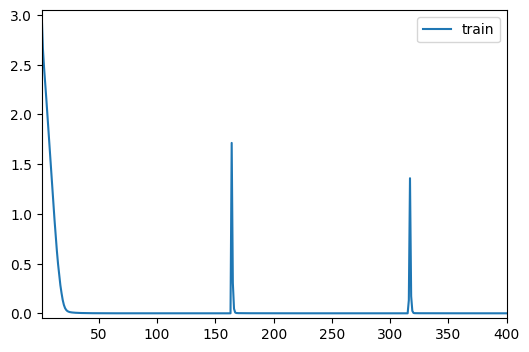

In [6]:
epochs = 400
mb = master_bar(range(1, epochs + 1))
train_loss = []

for epoch in mb:
    dataloader = DataLoader(dataset, batch_size=64, shuffle=True, drop_last=True)
    model.train()
    running_loss = 0.0
    for inputs in progress_bar(dataloader, parent=mb):
        codes = inputs['codes'].to(torch.int64)
        targets = inputs['label']
        one_hot_targets = F.one_hot(targets, num_classes=24).to(torch.float)

        optimizer.zero_grad()
        outputs = model(codes)
        loss = loss_function(outputs, targets)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    epoch_loss = running_loss / len(dataloader)
    train_loss.append(epoch_loss)

    mb.write(f'Epoch {epoch}: Train Loss: {epoch_loss:.4f}')
    
    graphs = [[range(1, epoch + 1), train_loss]]
    x_bounds = [1, epochs]
    y_bounds = [min(train_loss) - 0.05, max(train_loss) + 0.05]
    mb.update_graph(graphs, x_bounds, y_bounds)

In [7]:
model.eval()

true_labels = []
predicted_labels = []

with torch.no_grad():
    for inputs in dataloader:
        codes = inputs['codes'].to(torch.int64)
        targets = inputs['label']
        true_labels.extend(targets.cpu().numpy())
        outputs = model(codes)
        _, predicted = torch.max(outputs, 1)
        predicted_labels.extend(predicted.cpu().numpy())

accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
print(f'Accuracy on the training set: {accuracy * 100:.2f}%')

f1 = f1_score(true_labels, predicted_labels, average='weighted')
print(f'F1 Score on the training set: {f1:.2f}')

Accuracy on the training set: 100.00%
F1 Score on the training set: 1.00


In [ ]:
participants = set(dataset['participant'].unique())

results = []

for test_participant in participants:
    print(f"Training excluding Participant {test_participant}")
    train_indices = [i for i, p in enumerate(dataset['participant']) if p != test_participant]
    test_indices = [i for i, p in enumerate(dataset['participant']) if p == test_participant]
    train_data = dataset.select(train_indices)
    test_data = dataset.select(test_indices)
    model = SequenceModel().to("cuda")
    optimizer = optim.AdamW(model.parameters(), lr=0.001)

    for epoch in range(1, epochs + 1):
        train_dataloader = DataLoader(train_data, batch_size=64, shuffle=True, drop_last=True)
        model.train()
        running_loss = 0.0
        for inputs in train_dataloader:
            codes = inputs['codes'].to(torch.int64)
            targets = inputs['label']
            one_hot_targets = F.one_hot(targets, num_classes=24).to(torch.float)
            optimizer.zero_grad()
            outputs = model(codes)
            loss = loss_function(outputs, targets)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        epoch_loss = running_loss / len(train_dataloader)
        print(f'Epoch {epoch}/{epochs}, Participant {test_participant}: Loss = {epoch_loss:.4f}')
    
    test_dataloader = DataLoader(test_data, batch_size=64, shuffle=False, drop_last=True)
    model.eval()
    true_labels = []
    predicted_labels = []

    with torch.no_grad():
        for inputs in test_dataloader:
            codes = inputs['codes'].to(torch.int64)
            targets = inputs['label']
            true_labels.extend(targets.cpu().numpy())
            outputs = model(codes)
            _, predicted = torch.max(outputs, 1)
            predicted_labels.extend(predicted.cpu().numpy())

    accuracy = np.mean(np.array(true_labels) == np.array(predicted_labels))
    f1 = f1_score(true_labels, predicted_labels, average='weighted')

    print(f'LOPO Test Participant {test_participant}: Accuracy = {accuracy * 100:.2f}%, F1 Score = {f1:.2f}')
    results.append((test_participant, accuracy, f1))

Training excluding Participant 2
Epoch 1/400, Participant 2: Loss = 2.9752
Epoch 2/400, Participant 2: Loss = 2.6113
Epoch 3/400, Participant 2: Loss = 2.4287
Epoch 4/400, Participant 2: Loss = 2.2758
Epoch 5/400, Participant 2: Loss = 2.1191
Epoch 6/400, Participant 2: Loss = 1.9613
Epoch 7/400, Participant 2: Loss = 1.7951
Epoch 8/400, Participant 2: Loss = 1.6242
Epoch 9/400, Participant 2: Loss = 1.4511
Epoch 10/400, Participant 2: Loss = 1.2876
Epoch 11/400, Participant 2: Loss = 1.1171
Epoch 12/400, Participant 2: Loss = 0.9623
Epoch 13/400, Participant 2: Loss = 0.8143
Epoch 14/400, Participant 2: Loss = 0.6608
Epoch 15/400, Participant 2: Loss = 0.5298
Epoch 16/400, Participant 2: Loss = 0.4175
Epoch 17/400, Participant 2: Loss = 0.3160
Epoch 18/400, Participant 2: Loss = 0.2271
Epoch 19/400, Participant 2: Loss = 0.1593
Epoch 20/400, Participant 2: Loss = 0.1054
Epoch 21/400, Participant 2: Loss = 0.0682
Epoch 22/400, Participant 2: Loss = 0.0412
Epoch 23/400, Participant 2: L